# Example Notebook to conduct visualizations using OpenSearch Data


Initialize OpenSearch

In [2]:
import os

from dotenv import load_dotenv
from opensearchpy import OpenSearch

load_dotenv()

host = os.getenv("ELASTIC_HOST") 
port = os.getenv("ELASTIC_PORT")
auth = (os.getenv("ELASTIC_USER"), os.getenv("ELASTIC_PASSWORD"))

# Create the client with SSL/TLS and hostname verification disabled.
client = OpenSearch(
    hosts=[{'host': host, 'port': port, 'scheme': 'https'}],
    http_compress=True, # enables gzip compression for request bodies
    http_auth=auth,
    use_ssl=True,
    verify_certs=False,
    ssl_assert_hostname=False,
    ssl_show_warn=False
)

index_name = "phytooracle-index"

- Intialize other tools - Pandas, MatPlotLib etc.  

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
# Example of an index item

"""
    {
        "plant_name": "PI_678362_8409_330776657762",
        "genotype": "PI_678362_8409",
        "season": 14,
        "crop_type": "sorghum",
        "year_of_planting": 2022,
        "level": 2,
        "instrument": "scanner3DTop",
        "scan_date": "20220718T195858.520-0700",
        "species": "sorghum bicolor",
        "accession": "PI 678362",
        "fb_entry_id": "Az22-82",
        "seed_src_id": "WL19-BL241-1",
        "replicated_in_2020": "No",
        "treat": "WW",
        "rep": 1,
        "range": 84,
        "row": 9,
        "fb_type": "experimental",
        "plot": 8409,
        "id": "PI_678362_8409_330776657762_20220718T195858.520-0700"
    }
"""

'\n    {\n        "plant_name": "PI_678362_8409_330776657762",\n        "genotype": "PI_678362_8409",\n        "season": 14,\n        "crop_type": "sorghum",\n        "year_of_planting": 2022,\n        "level": 2,\n        "instrument": "scanner3DTop",\n        "scan_date": "20220718T195858.520-0700",\n        "species": "sorghum bicolor",\n        "accession": "PI 678362",\n        "fb_entry_id": "Az22-82",\n        "seed_src_id": "WL19-BL241-1",\n        "replicated_in_2020": "No",\n        "treat": "WW",\n        "rep": 1,\n        "range": 84,\n        "row": 9,\n        "fb_type": "experimental",\n        "plot": 8409,\n        "id": "PI_678362_8409_330776657762_20220718T195858.520-0700"\n    }\n'

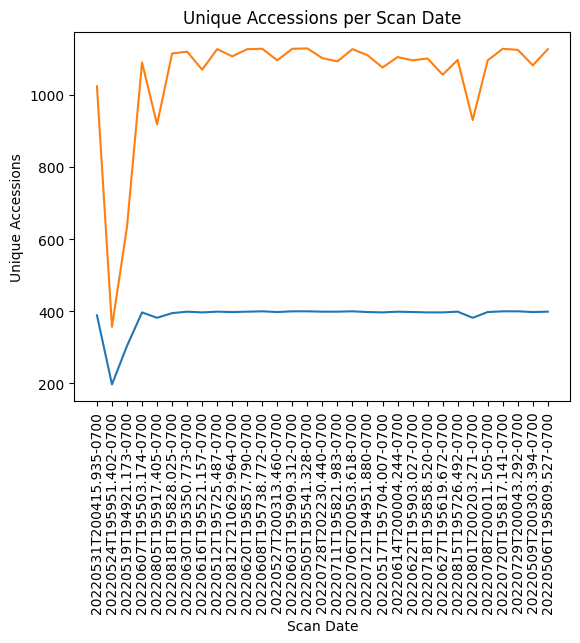

In [7]:
# Create a sample visualization mapping scan date to the count of unique accessions

body = {
    "size": 0,
    "aggs": {
        "scan_date": {
            "terms": {
                "field": "scan_date.keyword",
                "size": 1000
            },
            "aggs": {
                "accession": {
                    "cardinality": {
                        "field": "accession.keyword"
                    }
                }
            }
        }
    }
}

response = client.search(index=index_name, body=body)

scan_dates = []
accession_counts = []

for scan_date in response["aggregations"]["scan_date"]["buckets"]:
    scan_dates.append(scan_date["key"])
    accession_counts.append(scan_date["accession"]["value"])
# Scan dates are not sorted, so we need to sort them
scan_dates_accessions, accession_counts = zip(*sorted(zip(scan_dates, accession_counts)))

# Similarly, do the same for the number of unique genotypes
body = {
    "size": 0,
    "aggs": {
        "scan_date": {
            "terms": {
                "field": "scan_date.keyword",
                "size": 1000
            },
            "aggs": {
                "genotype": {
                    "cardinality": {
                        "field": "genotype.keyword"
                    }
                }
            }
        }
    }
}

response = client.search(index=index_name, body=body)

scan_dates = []
genotype_counts = []

for scan_date in response["aggregations"]["scan_date"]["buckets"]:
    scan_dates.append(scan_date["key"])
    genotype_counts.append(scan_date["genotype"]["value"])

scan_dates_genotypes, genotype_counts = zip(*sorted(zip(scan_dates, genotype_counts)))




plt.plot(scan_dates, accession_counts, color='red')
plt.plot(scan_dates, genotype_counts, color='blue')

# Add a legend
plt.legend(["Accessions", "Genotypes"])

plt.xlabel("Scan Date")
plt.ylabel("Unique Accession & Genotype Counts")
plt.title("Unique Accessions per Scan Date")

plt.xticks(rotation=90)
plt.show()

